# Applied Data Science Solutions for first Kaggle competition.
This is an example of how to prepare data and build prediction models using such ML models as Linear Regression, Logistic Regression, LinearSVC, Full Dence NN and Convolutional Neural Network. <br>
Dataset: Titanic dataset (https://www.kaggle.com/c/titanic/data)

### Classifier evaluation
Some code (will be) dedicated to the model evaluation in the ML (and other classification algorithms)<br>
related topics: <br>
https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html <br>
https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f <br>
Binary Classifier Evaluation Without Ground Truth - https://hal.inria.fr/hal-01680358

## **Import modules and libraries**

In [1]:
# for data manipulations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# for Machine Learning operations
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import Perceptron
#from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVC#, LinearSVC
#from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics

## ** Import Titanic dataset **

In [2]:
# import data
train = pd.read_csv('data/train_titanic.csv')
test = pd.read_csv('data/test_titanic.csv')

# check number of rows & columns
print(train.shape, test.shape, '\n\n How the input data looks like:')
train.head()

(891, 9) (418, 8) 

 How the input data looks like:


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,male,22.0,1,0,7.2500,S,0
1,2,1,female,38.0,1,0,71.2833,C,1
2,3,3,female,26.0,0,0,7925.0000,S,1
3,4,1,female,35.0,1,0,53.1000,S,1
4,5,3,male,35.0,0,0,8.0500,S,0


## ** 1. Data Pre-Processing **

1.1 Let's transform categorical values 'Sex' and 'Embarked' to the numerical:

In [3]:
import warnings
warnings.filterwarnings("ignore")

y = train.Survived; train = train.drop('Survived', axis=1)
#combine = pd.concat([train, test])

cleanup_val = {"Sex":     {"male": 1, "female": 0},
              "Embarked": {"S": 0, "C": 1, "Q": 2}}
test.replace(cleanup_val, inplace = True)
train.replace(cleanup_val, inplace = True)

1.2 Fill missed values in 'Age', 'Fare' and 'Embarked' columns:

In [4]:
combine = [test, train]
for dataframe in combine:
    dataframe.Age = dataframe.Age.fillna(value=np.mean(dataframe.Age))
    dataframe.Embarked = dataframe.Embarked.fillna(value=0)
    dataframe.Fare = dataframe.Fare.fillna(value=np.mean(dataframe.Fare))
    #print(dataframe.info())

1.3 Separate 'Age' and 'Fare' values on bands.

In case we have very little set of data (and it is our case) - we can automatically use Grid Search and find the best parameters (best number of bands for the float variables) according to the model prediction accuracy (on the validation or test set).

Now I think it is reasonable to choose 6 bands for both parameters - 'Age' and 'Fare' (I checked distribution of the parameter 'Survived'). But I can be wrong in that.


In [5]:
train['FareBand'] = pd.qcut(train['Fare'], 6)
train['AgeBand'] = pd.qcut(train['Age'], 6)
#print('Fare Bands: ', train.FareBand.unique().sort_values(ascending=True),'\n\n')
#print('Age Bands: ', train.AgeBand.unique().sort_values(ascending=True))

In [6]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 18, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 23), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 23) & (dataset['Age'] <= 28), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 28) & (dataset['Age'] <= 34), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 34) & (dataset['Age'] <= 44), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 44, 'Age'] = 5
    
    dataset.loc[ dataset['Fare'] <= 7.98, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.98) & (dataset['Fare'] <= 10.5), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 10.5) & (dataset['Fare'] <= 19.5), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 19.5) & (dataset['Fare'] <= 33.0), 'Fare'] = 3
    dataset.loc[(dataset['Fare'] > 33.0) & (dataset['Fare'] <= 110.22), 'Fare'] = 4
    dataset.loc[ dataset['Fare'] > 110.22, 'Fare'] = 5

train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FareBand,AgeBand
0,1,3,1,1.0,1,0,0.0,0.0,"(-0.001, 7.89]","(19.0, 25.0]"
1,2,1,0,4.0,1,0,4.0,1.0,"(33.0, 110.222]","(31.0, 40.5]"
2,3,3,0,2.0,0,0,5.0,0.0,"(110.222, 262375.0]","(25.0, 29.699]"
3,4,1,0,4.0,1,0,4.0,0.0,"(33.0, 110.222]","(31.0, 40.5]"
4,5,3,1,4.0,0,0,1.0,0.0,"(7.89, 10.5]","(31.0, 40.5]"


1.4 Summarize SibSp (siblings / spouses) and Parch (Parents / children) columns to one: 'Family'<br>
1.5 Higlight who is alone (create new column 'IsAlone') <br>
1.6 Convert all the values to the INT type

In [7]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Fare'] = dataset['Fare'].astype(int)
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Embarked'] = dataset['Embarked'].astype(int)
    #dataset['Class*Age'] = dataset['Pclass'] * dataset['Age']


train = train.drop(['SibSp', 'Parch','FareBand', 'AgeBand'], axis = 1)
test = test.drop(['SibSp', 'Parch', 'SibSp', 'Parch'], axis = 1)

1.6 Turn column 'PassengerId' to indexes:

In [8]:
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

## **Data visualization**

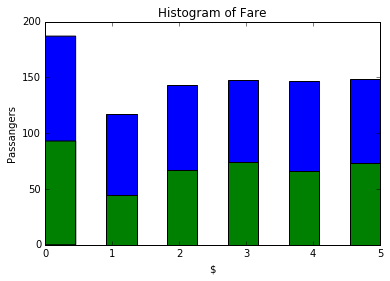

             Pclass  Sex  Age  Fare  Embarked  FamilySize  IsAlone
PassengerId                                                       
1                 3    1    1     0         0           2        0
2                 1    0    4     4         1           2        0
3                 3    0    2     5         0           1        1
             Pclass  Sex  Age  Fare  Embarked  FamilySize  IsAlone
PassengerId                                                       
892               3    1    4     0         2           1        1
893               3    0    5     0         0           2        0
894               2    1    5     1         2           1        1


In [9]:
train['Fare'].plot.hist(11)
test['Fare'].plot.hist(11)
plt.title('Histogram of Fare')
plt.xlabel('$'); plt.ylabel('Passangers'); plt.show()

print(train.head(3))
print(test.head(3))

## **Split dataset to Train and Validation set**

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify = y)
# Class relations
print(Y_train.value_counts()/Y_train.count())
print(Y_valid.value_counts()/Y_valid.count())

0    0.616573
1    0.383427
Name: Survived, dtype: float64
0    0.614525
1    0.385475
Name: Survived, dtype: float64


## **Logistic Regression model**

In [11]:
model = LogisticRegression()
%time model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)
model_acc = model.score(X_valid, Y_valid) * 100
print('\nValidation Accuracy:\t', round(model_acc, 3))
print('Train Accuracy:\t\t', round(model.score(X_train, Y_train) * 100, 3))

CPU times: user 8.93 ms, sys: 143 µs, total: 9.08 ms
Wall time: 13.4 ms

Validation Accuracy:	 81.006
Train Accuracy:		 80.197


#### ** Save result for the submission: **

In [12]:
PredictedData = pd.DataFrame(model.predict(test),
                             index=test.index.values,
                             columns=['Survived'])
PredictedData.index.name = 'PassengerId'
PredictedData['Survived'].reset_index().to_csv('LogReg.csv', index = False)

## **Support Vector Machines model**

In [13]:
model = SVC()
%time model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)
model_acc = model.score(X_valid, Y_valid) * 100
print('\nValidation Accuracy:\t', round(model_acc, 3))
print('Train Accuracy:\t\t', round(model.score(X_train, Y_train) * 100, 3))

CPU times: user 47.4 ms, sys: 0 ns, total: 47.4 ms
Wall time: 55.1 ms

Validation Accuracy:	 82.123
Train Accuracy:		 82.865


#### ** Save result for the submission: **

In [14]:
PredictedData = pd.DataFrame(model.predict(test),
                             index=test.index.values,
                             columns=['Survived'])
PredictedData.index.name = 'PassengerId'
PredictedData['Survived'].reset_index().to_csv('SVM.csv', index = False)

## **k-Nearest Neighbors algorithm (KNN)**

In [15]:
model = KNeighborsClassifier(n_neighbors = 5)
%time model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)
model_acc = model.score(X_valid, Y_valid) * 100
print('\nValidation Accuracy:\t', round(model_acc, 3))
print('Train Accuracy:\t\t', round(model.score(X_train, Y_train) * 100, 3))

CPU times: user 3.43 ms, sys: 0 ns, total: 3.43 ms
Wall time: 10.6 ms

Validation Accuracy:	 74.302
Train Accuracy:		 84.41


#### ** Save result for the submission: **

In [16]:
PredictedData = pd.DataFrame(model.predict(test),
                             index=test.index.values,
                             columns=['Survived'])
PredictedData.index.name = 'PassengerId'
PredictedData['Survived'].reset_index().to_csv('KNN.csv', index = False)

## ** Random Forest **

In [17]:
model = RandomForestClassifier(n_estimators=100)
%time model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)
model.score(X_train, Y_train)
model_acc = round(model.score(X_valid, Y_valid) * 100, 2)
print('\nValidation Accuracy:\t', round(model_acc, 3))
print('Train Accuracy:\t\t', round(model.score(X_train, Y_train) * 100, 3))

CPU times: user 611 ms, sys: 18 ms, total: 629 ms
Wall time: 880 ms

Validation Accuracy:	 81.56
Train Accuracy:		 90.309


#### ** Save result for the submission: **

In [18]:
PredictedData = pd.DataFrame(model.predict(test),
                             index=test.index.values,
                             columns=['Survived'])
PredictedData.index.name = 'PassengerId'
PredictedData['Survived'].reset_index().to_csv('RandForest.csv', index = False)

## **Multi-Layer Perceptron Classifier model**

In [21]:
from sklearn.neural_network import MLPClassifier

In [42]:
mlp_model = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=1000)
%time mlp_model.fit(X_train,Y_train)

predictions = mlp_model.predict(X_valid)
print(classification_report(Y_valid,predictions).precision)

model_acc = round(mlp_model.score(X_valid, Y_valid) * 100, 2)
print('\nValidation Accuracy:\t', round(model_acc, 3))
print('Train Accuracy:\t\t', round(model.score(X_train, Y_train) * 100, 3))

CPU times: user 1.36 s, sys: 3.36 ms, total: 1.37 s
Wall time: 1.46 s


AttributeError: 'str' object has no attribute 'precision'

In [40]:
PredictedData = pd.DataFrame(mlp_model.predict(test),
                             index=test.index.values,
                             columns=['Survived'])
PredictedData.index.name = 'PassengerId'
PredictedData['Survived'].reset_index().to_csv('MLPerceptron.csv', index = False)

## ** K-fold Cross-validation **
K-fold Cross-validation is a technique for model evaluation and model selection.
##### Pros:
    + Better estimate of out-of-sample performance than simple train/test split

##### Cons:
    - Runs "K" times slower than simple train/test split

If we have **little data** and **enough time**, it's better to always do cross-validation for a more precise estimate of performance.

In [ ]:
# fit model 
from sklearn.model_selection import GridSearchCV

#params = dict(classifier__C=[0.15, 0.25, 0.35])
#print(params)
#grid_search = GridSearchCV(pipeline, param_grid=params, cv=10)
#X_train, Y_train
#%time grid_search.fit(X_train, Y_train)

In [ ]:
# Best parameters found:
#grid_search.best_params_

In [ ]:
# Average accuracy over K folds for best parameters set
#print("Validation Accuracy", grid_search.best_score_)

### <a name="3.4"></a>ROC AUC
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

More details here:
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

///![](https://i.stack.imgur.com/5x3Xj.png)

